
Loading data from ../data/mildura/parameters_mildura_experiments.xlsx ... 
You are missing at least one of (lat,lon,timezone_offset) in:
../data/mildura/parameters_mildura_experiments.xlsx
Field performance cannot be simulated until all of these are defined. 

Importing constants

Loading data from ../data/mildura/parameters_mildura_experiments.xlsx ... 
You are missing at least one of (lat,lon,timezone_offset) in:
../data/mildura/parameters_mildura_experiments.xlsx
Field performance cannot be simulated until all of these are defined. 

Importing constants
No mu_tilde model defined in ../data/mildura/parameters_mildura_experiments.xlsx. You will need to define this before simulating
Importing site data (weather,time). Using dust_type = PM10, test_length = 5 days
Length of simulation for file ../data/mildura/experiment_20240130_20240205.xlsx: 5 days
No DNI data to import. Skipping.
No rain intensity data to import.
Importing relative humidity data...
Importing wind direction data ...
I

c:\Users\picotti\OneDrive - Queensland University of Technology\PostDoc\GitHub_projects\HelioSoil\analysis_scripts\..\soiling_model\utilities.py:362: RuntimeWarning: invalid value encountered in divide
  ref_dat_new.sigma[f][:,ii] = np.sqrt(sum_var/N) # pooled variance


Setting tilts for 1 experiments
Second surface model
Loss Model is mie. Computing extinction coefficients ... 


File 0:   0%|          | 0/1 [00:00<?, ?it/s]

	 Computing weights for file 0, heliostat 0...
	 Acceptance angle cosine = 0.999922


File 0: 100%|██████████| 1/1 [01:29<00:00, 89.73s/it]


... Done!
Setting tilts for 1 experiments
Second surface model
Getting initial deposition parameter guess via least squares
Getting initial sigma_dep guess via MLE (at least-squares value for deposition parameters)
x0 = [194.43639679453005, 0.0001390298525736259]
Maximizing likelihood ...
  Optimization terminated successfully.
Estimating parameter covariance using numerical approximation of Hessian ... 


c:\Users\picotti\OneDrive - Queensland University of Technology\PostDoc\GitHub_projects\HelioSoil\analysis_scripts\..\soiling_model\fitting.py:533: RuntimeWarning: overflow encountered in exp
  z = np.array( [np.exp(np.exp(x[0])),np.exp(x[1])] )


... done!

log(log(hrz0)) = 1.83e+00, sigma_dep = -8.89e+00
95% confidence interval for log(log(hrz0)): [1.01e-01, 3.57e+00]
95% confidence interval for log(sigma_dep): [-9.53e+00, -8.25e+00]
hrz0: 5.21e+02 [3.02e+00,2.30e+15]
\sigma_dep: 1.38e-04 [7.27e-05,2.60e-04] [p.p./day]
Getting MLE estimates ... 
========== MLE Estimates ======== 
log(mu_tilde) = -1.13e+01, log(sigma_dep) = -8.86e+00 
95% confidence interval for log(mu_tilde): [-1.21e+01, -1.05e+01]
95% confidence interval for log(sigma_dep): [-9.50e+00, -8.23e+00]
mu_tilde: 1.27e-05 [5.72e-06,2.84e-05] [p.p./day]
\sigma_dep (constant mean model): 1.42e-04 [7.48e-05,2.68e-04] [p.p./day]
Setting tilts for 1 experiments
Second surface model
Loss Model is mie. Computing extinction coefficients ... 


File 0:   0%|          | 0/1 [00:00<?, ?it/s]

	 Computing weights for file 0, heliostat 0...
	 Acceptance angle cosine = 0.999922


File 0: 100%|██████████| 1/1 [01:34<00:00, 94.28s/it]


... Done!
Setting tilts for 1 experiments
Second surface model
No value for hrz0 supplied. Using value in self.hrz0 = 521.3320915121006.
Calculating deposition velocity for each of the 1 simulations
Aerodynamic resistance is considered
Calculating adhesion/removal balance
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
Calculating soil deposited in a timestep [m^2/m^2]
Calculating soil deposited in a timestep [m^2/m^2]


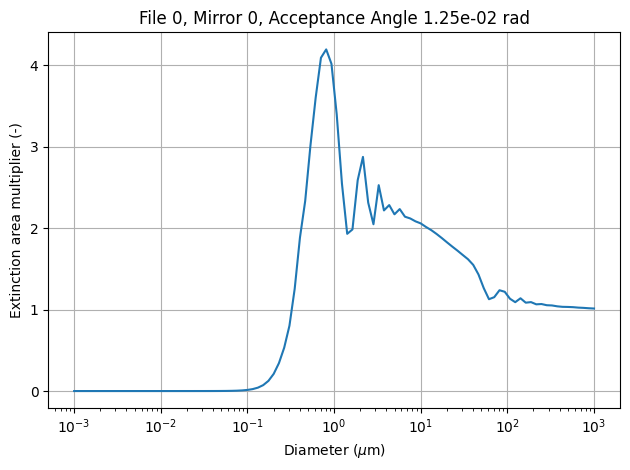

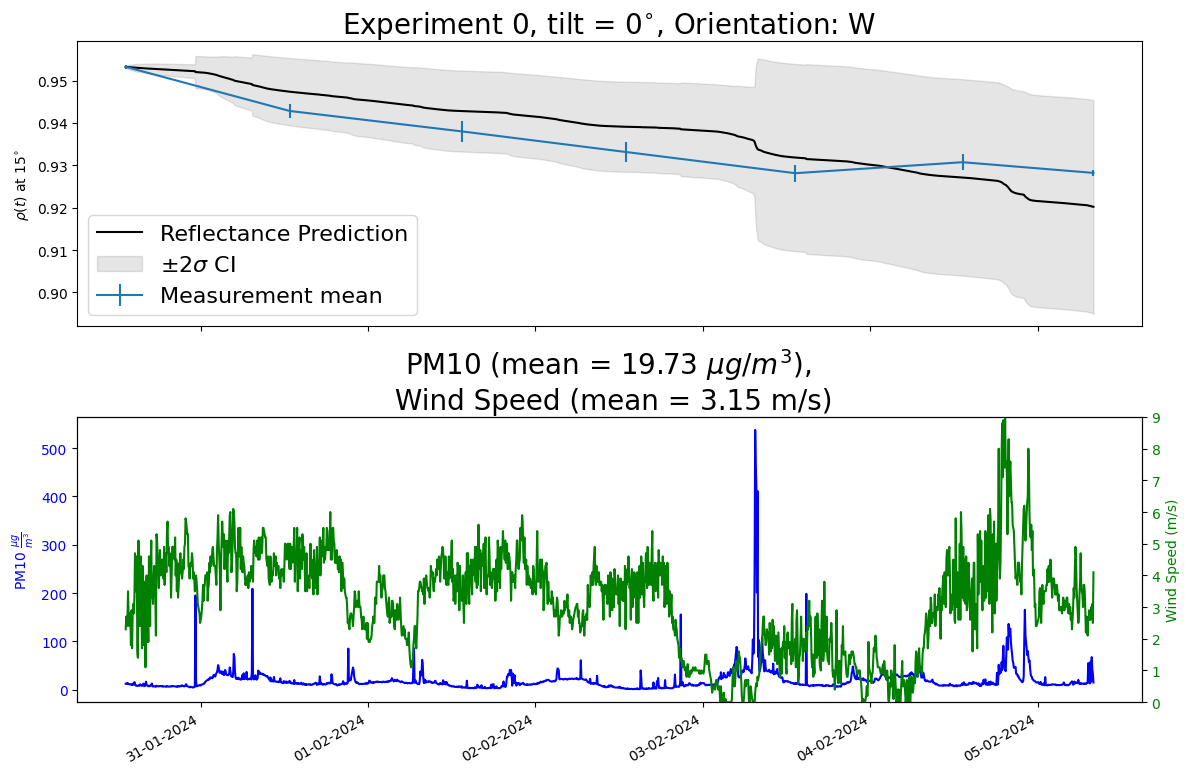

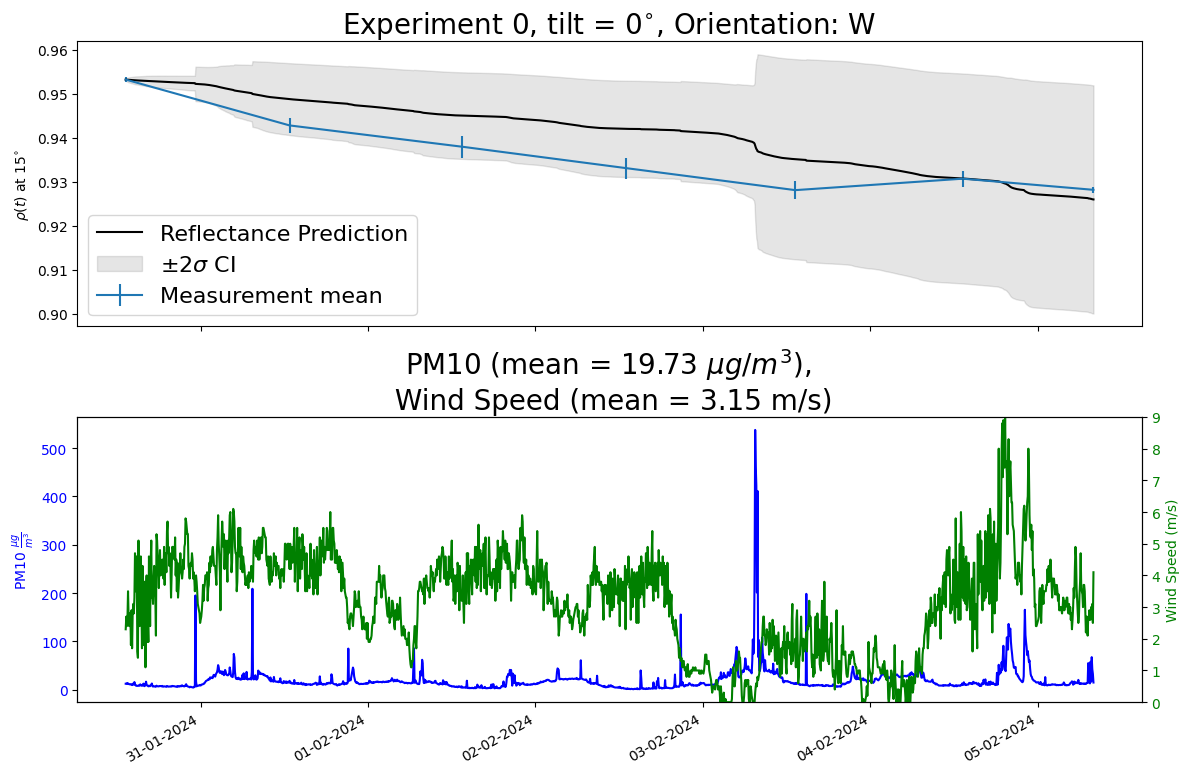

In [1]:
# %% Analysis of Carwarp data
main_directory = ".."
import os
os.sys.path.append(main_directory)

# CHOOSE WHETHER TO USE DAILY AVERAGE OF REFLECTANCE VALUES OR NOT
DAILY_AVERAGE = True

# CHOOSE WHETHER TO WORK ON HELIOSTATS OR ON THE MIRROR RIG
HELIOSTATS = True

# %% modules
import numpy as np
import pandas as pd
import soiling_model.base_models as smb
import soiling_model.fitting as smf
import soiling_model.utilities as smu
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# from paper_specific_utilities import plot_for_paper, plot_for_heliostats, daily_soiling_rate, \
#                                      fit_quality_plots, summarize_fit_quality

pad = 0.05
sp_save_file = f"{main_directory}/results/sp_fitting_results_mildura"
cm_save_file = f"{main_directory}/results/cm_fitting_results_mildura"
reflectometer_incidence_angle = 15 # [deg] angle of incidence of reflectometer
reflectometer_acceptance_angle = 12.5e-3 # [rad] half acceptance angle of reflectance measurements
second_surf = True # True if using the second-surface model. Otherwise, use first-surface
d = f"{main_directory}/data/mildura/"
time_to_remove_at_end = [0,0,0,0,0,0]
train_experiments = [0] # indices for training experiments from 0 to len(files)-1
train_mirrors = ["ON_M1_T00"]#,"ONW_M5_T00"] # which mirrors within the experiments are used for training
k_factor = "import" # None sets equal to 1.0, "import" imports from the file
dust_type = "PM10" # choose PM fraction to use for analysis --> PMT, PM10, PM2.5

# %% Get file list and time intervals. Import training data.
parameter_file = d+"parameters_mildura_experiments.xlsx"

files,all_intervals,exp_mirrors,all_mirrors = smu.get_training_data(d,"experiment_",time_to_remove_at_end=time_to_remove_at_end)
orientation = [ [s[1] for s in mirrors] for mirrors in exp_mirrors]

# January 2024 (first experiments --- nothing to remove)
all_intervals[0][0] = np.datetime64('2024-01-30T10:00:00')
all_intervals[0][1] = np.datetime64('2024-02-05T09:00:00')  # mirrors data at 8am, heliostats data at 9am

# June 2024 (second experiments --- already removed rainy data - consider adding them back)
all_intervals[1][0] = np.datetime64('2024-06-06T17:00:00')
all_intervals[1][1] = np.datetime64('2024-06-11T08:00:00')

testing_intervals = all_intervals
        
Nfiles = len(files)
extract = lambda x,ind: [x[ii] for ii in ind]
files_train = extract(files,train_experiments)
training_intervals = extract(all_intervals,train_experiments)
testing_intervals = list(all_intervals)
t = [t for t in train_experiments]
plot_title = "Training: "+str(train_mirrors)+", Exp: "+str(t)

# %% Import training data
imodel = smf.semi_physical(parameter_file)
imodel_constant = smf.constant_mean_deposition(parameter_file)
sim_data_train = smb.simulation_inputs( files_train,
                                        k_factors=k_factor,
                                        dust_type=dust_type
                                        )
reflect_data_train = smb.reflectance_measurements(  files_train,
                                                    sim_data_train.time,
                                                    number_of_measurements=6.0,
                                                    reflectometer_incidence_angle=reflectometer_incidence_angle,
                                                    reflectometer_acceptance_angle=reflectometer_acceptance_angle,
                                                    import_tilts=True,
                                                    column_names_to_import=train_mirrors
                                                    )
# %% Trim training data 
sim_data_train,reflect_data_train = smu.trim_experiment_data(   sim_data_train,
                                                                reflect_data_train,
                                                                training_intervals 
                                                            )
                                                            
sim_data_train,reflect_data_train = smu.trim_experiment_data(   sim_data_train,
                                                                reflect_data_train,
                                                                "reflectance_data" 
                                                            )

# %% Load total simulation data

if HELIOSTATS==True:
    files,_,exp_mirrors,all_mirrors = smu.get_training_data(d,"hel_experiment_",time_to_remove_at_end=time_to_remove_at_end)


sim_data_total = smb.simulation_inputs( files,
                                        k_factors=k_factor,
                                        dust_type=dust_type
                                        )

# %% Load total reflectance data
if HELIOSTATS:
    n_meas = 36.0
else:
    n_meas = 6.0
    
reflect_data_total = smb.reflectance_measurements(  files,
                                                    sim_data_total.time,
                                                    number_of_measurements=n_meas,
                                                    reflectometer_incidence_angle=reflectometer_incidence_angle,
                                                    reflectometer_acceptance_angle=reflectometer_acceptance_angle,
                                                    import_tilts=True,
                                                    column_names_to_import=None
                                                    )

# %% Trim data and plot                                                           
sim_data_total,reflect_data_total = smu.trim_experiment_data(   sim_data_total,
                                                                reflect_data_total,
                                                                "reflectance_data" 
                                                            )

if DAILY_AVERAGE:
    reflect_data_train = smu.daily_average(reflect_data_train,sim_data_train.time,sim_data_train.dt)    # compute daily_averaged values of reflectance to avoid morning-afternoon (not understood) recoveries
    # sim_data_train , _ = smu.trim_experiment_data(      sim_data_train,                                 # trim the correspoding simulation inputs to align with the new reflectance values (start and end time can be modified by the average)
    #                                                 reflect_data_train,
    #                                                 "reflectance_data")
    
# %% Daily average of reflectance values and trimming of simulation inputs (Total data)

if DAILY_AVERAGE:
    reflect_data_total = smu.daily_average(reflect_data_total,sim_data_total.time,sim_data_total.dt)
    # sim_data_total , _ = smu.trim_experiment_data(      sim_data_total,
    #                                                 reflect_data_total,
    #                                                 "reflectance_data" )


# %% Set mirror angles and get extinction weights for fitting (using train data)
imodel.helios_angles(sim_data_train,reflect_data_train,second_surface=second_surf)
imodel.helios.compute_extinction_weights(sim_data_train,imodel.loss_model,verbose=True)
imodel.helios.plot_extinction_weights(sim_data_train,fig_kwargs={})
ext_weights = imodel.helios.extinction_weighting[0].copy()

imodel_constant.helios_angles(sim_data_train,reflect_data_train,second_surface=second_surf)
file_inds = np.arange(len(files_train))
imodel_constant = smu.set_extinction_coefficients(imodel_constant,ext_weights,file_inds)

# %% Fit semi-physical model 
log_param_hat,log_param_cov = imodel.fit_mle(   sim_data_train,
                                                reflect_data_train,
                                                transform_to_original_scale=False)

s = np.sqrt(np.diag(log_param_cov))
param_ci = log_param_hat + 1.96*s*np.array([[-1],[1]])
lower_ci = imodel.transform_scale(param_ci[0,:])
upper_ci = imodel.transform_scale(param_ci[1,:])
param_hat = imodel.transform_scale(log_param_hat)
hrz0_mle,sigma_dep_mle = param_hat
print(f'hrz0: {hrz0_mle:.2e} [{lower_ci[0]:.2e},{upper_ci[0]:.2e}]')
print(f'\sigma_dep: {sigma_dep_mle:.2e} [{lower_ci[1]:.2e},{upper_ci[1]:.2e}] [p.p./day]')

imodel.update_model_parameters(param_hat)
imodel.save(sp_save_file,
            log_p_hat=log_param_hat,
            log_p_hat_cov=log_param_cov,
            training_simulation_data=sim_data_train,
            training_reflectance_data=reflect_data_train)

# %% Fit constant mean model 
log_param_hat_con,log_param_cov_con = imodel_constant.fit_mle(  sim_data_train,
                                                                reflect_data_train,
                                                                transform_to_original_scale=False)
s_con = np.sqrt(np.diag(log_param_cov_con))
param_ci_con = log_param_hat_con + 1.96*s_con*np.array([[-1],[1]])
lower_ci_con = imodel_constant.transform_scale(param_ci_con[0,:])
upper_ci_con = imodel_constant.transform_scale(param_ci_con[1,:])
param_hat_con = imodel_constant.transform_scale(log_param_hat_con)
mu_tilde,sigma_dep_con = param_hat_con
print(f'mu_tilde: {mu_tilde:.2e} [{lower_ci_con[0]:.2e},{upper_ci_con[0]:.2e}] [p.p./day]')
print(f'\sigma_dep (constant mean model): {sigma_dep_con:.2e} [{lower_ci_con[1]:.2e},{upper_ci_con[1]:.2e}] [p.p./day]')

imodel_constant.update_model_parameters(param_hat_con)
imodel_constant.save(cm_save_file,
                     log_p_hat=log_param_hat_con,
                     log_p_hat_cov=log_param_cov_con,
                     training_simulation_data=sim_data_train,
                     training_reflectance_data=reflect_data_train)

# %% Compute daily averaged data of training data and updated imodel (DOES THIS MAKE SENSE?? IT IS DOING TWICE THE SAME JOB)
if DAILY_AVERAGE:
    sim_data_train , reflect_data_train = smu.trim_experiment_data( sim_data_train,      # trim the correspoding simulation inputs to align with the new reflectance values (start and end time can be modified by the average)
                                                                    reflect_data_train,
                                                                    "reflectance_data")
    
# %% updated imodel with new daily-averaged training data
if DAILY_AVERAGE:
    imodel.helios_angles(sim_data_train,reflect_data_train,second_surface=second_surf)
    imodel.helios.compute_extinction_weights(sim_data_train,imodel.loss_model,verbose=True)  # ASSESS HOW TO AVOID REPEATING COMPUTING THIS
    imodel_constant.helios_angles(sim_data_train,reflect_data_train,second_surface=second_surf)
    file_inds = np.arange(len(files_train))
    imodel_constant = smu.set_extinction_coefficients(imodel_constant,ext_weights,file_inds)


# %% plot SM on training data
_,_,_ = imodel.plot_soiling_factor( sim_data_train,
                            reflectance_data=reflect_data_train,
                            reflectance_std='mean',
                            save_path=f"{main_directory}/results/mildura_sp_training",
                            # fig_title="On Training Data (semi-physical)",
                            orientation_strings=orientation,
                            figsize=[12,8])

# %% plot CM on training data
_,_,_ = imodel_constant.plot_soiling_factor(    sim_data_train,
                                                reflectance_data=reflect_data_train,
                                                reflectance_std='mean',
                                                save_path=f"{main_directory}/results/mildura_cm_training",
                                                # fig_title="On Training Data",
                                                orientation_strings=orientation,
                                                figsize = [12,8]  )


# %% Compute daily averaged data of total data (DOES THIS MAKE SENSE?? IT IS DOING TWICE THE SAME JOB)
if DAILY_AVERAGE:
    sim_data_total , reflect_data_total = smu.trim_experiment_data( sim_data_total,      # trim the correspoding simulation inputs to align with the new reflectance values (start and end time can be modified by the average)
                                                                    reflect_data_total,
                                                                    "reflectance_data")



In [2]:
# %% Performance of semi-physical model on total data
imodel.helios_angles(sim_data_total,reflect_data_total,second_surface=second_surf)
file_inds = np.arange(len(reflect_data_total.file_name))
imodel = smu.set_extinction_coefficients(imodel,ext_weights,file_inds)

Setting tilts for 1 experiments
Second surface model


In [3]:
imodel_constant.helios_angles(sim_data_total,reflect_data_total,second_surface=second_surf)


Setting tilts for 1 experiments
Second surface model


In [24]:
len(imodel.helios.tilt[0][0])

1686

No value for hrz0 supplied. Using value in self.hrz0 = 521.3320915121006.
Calculating deposition velocity for each of the 1 simulations
Aerodynamic resistance is considered


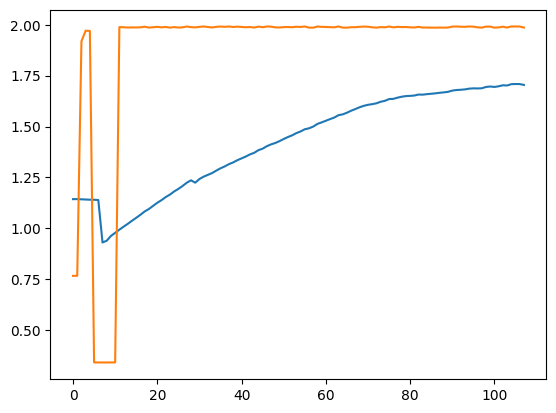

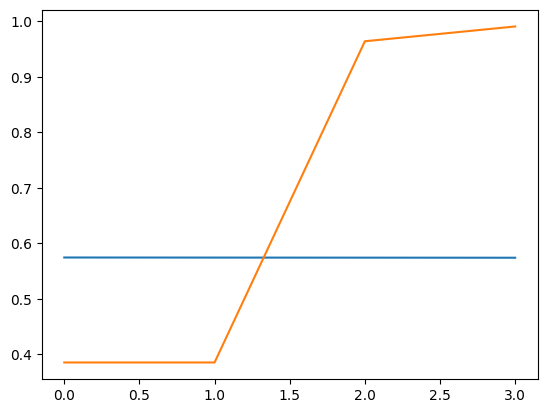

In [51]:
from numpy import radians as rad
# dir(imodel.helios)
imodel.helios.delta_soiled_area[0].shape
imodel.deposition_flux(sim_data_total)
imodel.helios.pdfqN[0][1][500+600:520+600]
imodel.helios.pdfqN[0][1].shape

plt.plot(imodel.helios.pdfqN[0][2][600+502:600+610:,82])
plt.plot(imodel.helios.pdfqN[0][1][600+502:600+610:,82])
plt.show()

plt.plot(np.cos(np.radians(imodel.helios.tilt[0][2][600+502:600+506])))
plt.plot(np.cos(np.radians(imodel.helios.tilt[0][1][600+502:600+506])))
# plt.ylim([0, 0.4])
plt.show()


# for h in range(len(imodel.helios.tilt[0])):
#     for k in range(len(imodel.helios.tilt[0][0])):
#         mom_removal = np.sin(rad(imodel.helios.tilt[f][h,k]))* F_gravity*np.sqrt((D_meters**2)/4-radius_sep**2) # [Nm] removal moment exerted by gravity at each tilt for each diameter
#         mom_adhesion =  (F_adhesion+F_gravity*np.cos(rad(imodel.helios.tilt[f][h,k])))*radius_sep             # [Nm] adhesion moment  
#         imodel.helios.pdfqN[f][h,k::,mom_adhesion<mom_removal] = 0 # ALL dust desposited at this diameter up to this point falls off

Calculating adhesion/removal balance
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.


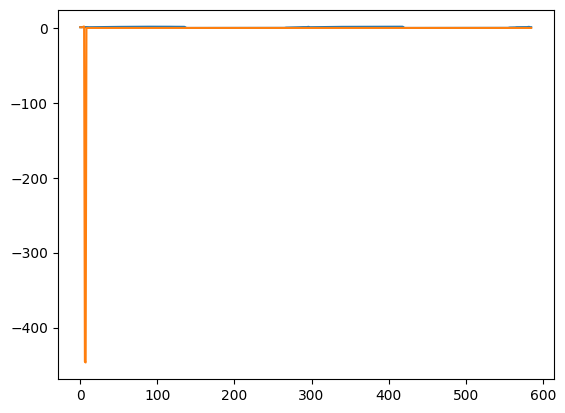

In [42]:
imodel.adhesion_removal(sim_data_total)

plt.plot(imodel.helios.pdfqN[0][2][600+500:,82])
plt.plot(imodel.helios.pdfqN[0][1][600+500:,82])
plt.show()

Calculating soil deposited in a timestep [m^2/m^2]


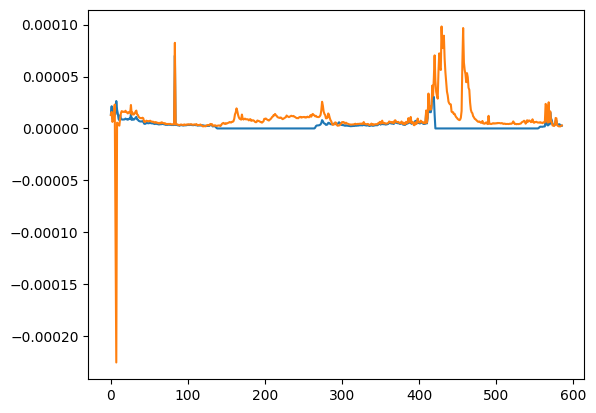

In [43]:
imodel.calculate_delta_soiled_area(sim_data_total)
plt.plot(imodel.helios.delta_soiled_area[0][2][600+500:])
plt.plot(imodel.helios.delta_soiled_area[0][1][600+500:])
plt.show()

In [32]:
imodel.helios.delta_soiled_area[0][0].shape




(1686,)

In [ ]:
from numpy import radians as rad
np.cos(rad(imodel.helios.tilt[0][1,600+505]))
print(imodel.helios.tilt[0][1,600+505])